In [18]:
import sys
sys.path.append("../")
sys.path.append("../inception-score-pytorch/")

In [6]:
from loss import compute_loss
from loss import compute_combined_loss
import networks as net
from data_sampler import data_sampler
from utl import *

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import clear_output

In [7]:
input_nc = 1
output_nc = 1
discr_filters = 8
max_power = 8
n_layers = 4
norm_lay = nn.BatchNorm2d
start_size = 28
gen_filters = 16
dropout = 0.7
n_blocks = 2
batch_size = 1
alpha = 10

In [8]:
train_pull = pd.read_csv("../../data/fashion_mnisit/train_pull.csv", header=None).values
train_top = pd.read_csv("../../data/fashion_mnisit/train_top.csv", header=None).values
# test_pull = pd.read_csv("../../data/fashion_mnisit/test_pull.csv", header=None).values
# test_top = pd.read_csv("../../data/fashion_mnisit/test_top.csv", header=None).values

In [9]:
discr_a = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size)

discr_b = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size)

gener_a = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

gener_b = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

In [10]:
gener_a.apply(weights_init)
gener_b.apply(weights_init)
discr_a.apply(weights_init)
discr_b.apply(weights_init)
print("weights initialized")

weights initialized


In [13]:
from itertools import chain
opt_discr = torch.optim.SGD(chain(discr_a.parameters(), discr_b.parameters()), lr=0.001)
opt_gener = torch.optim.SGD(chain(gener_a.parameters(), gener_b.parameters()), lr=0.001)
# opt_gener_a = torch.optim.Adam(gener_a.parameters(), lr=0.001)
# opt_gener_b = torch.optim.Adam(gener_b.parameters(), lr=0.001)
# opt_discr_a = torch.optim.Adam(discr_a.parameters(), lr=0.001)
# opt_discr_b = torch.optim.Adam(discr_b.parameters(), lr=0.001)

In [14]:
ga_loss_log = []
gb_loss_log = []
da_loss_log = []
db_loss_log = []

In [15]:
def conserve_loss(net):
    loss = Variable(torch.FloatTensor([0]), requires_grad=True)
    for param in net.parameters():
        try:
            loss = loss.add(F.mse_loss(param.grad, torch.zeros_like(param.grad)))
        except AttributeError:
            next
        except TypeError:
            return conserve_loss
    return loss

In [19]:
from inception_score import inception_score

In [27]:
inception_score(data_sampler(100, train_pull, train_top)[0].view(-1, 1, 28, 28).data, cuda=False, batch_size=10, resize=True)

/anaconda/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


RuntimeError: Given groups=1, weight[32, 3, 3, 3], so expected input[10, 1, 299, 299] to have 3 channels, but got 1 channels instead

In [ ]:
inception_score()

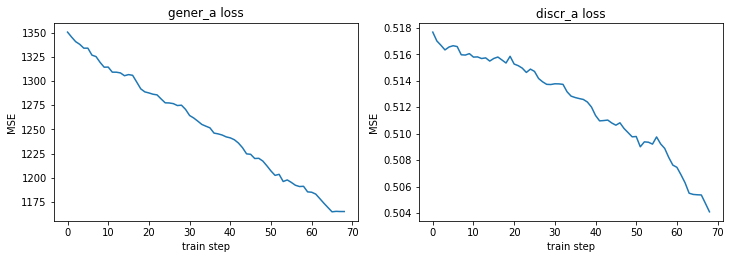

KeyboardInterrupt: 

In [17]:
for i in range(1, 100):
    batch_a, batch_b = data_sampler(batch_size, train_pull, train_top)
    batch_a = batch_a.view(-1, 1, 28, 28).float()
    batch_b = batch_b.view(-1, 1, 28, 28).float()
    gener_a.train()
    gener_b.train()
    discr_a.train()
    discr_b.train()
    
    losses = compute_combined_loss(
        gener_a, gener_b,
        discr_a, discr_b,
        batch_a, batch_b,
        alpha,
        discr_loss = 'mse',
        use_gpu=False
    )
    
    discr_loss, gener_loss = losses[0:2]
    da_loss, db_loss = losses[2:4]
    ga_loss, gb_loss = losses[4:6]
    ga_fool, gb_fool = losses[6:8]
    
    if i % 2 == 0:
        opt_discr.zero_grad()
        discr_loss.backward()
        opt_discr.step()
    else:
        opt_gener.zero_grad()
        gener_loss.backward()
        opt_gener.step()
    
    ga_loss_log.append(ga_fool.data[0])
    gb_loss_log.append(gb_fool.data[0])
    da_loss_log.append(da_loss.data[0])
    db_loss_log.append(db_loss.data[0])
    
    if (i+1) % 100 == 0:
        clear_output()
        visualize_loss(da_loss_log, db_loss_log, ga_loss_log, gb_loss_log, exp_window=250)
        ind = np.random.randint(0, batch_size, 1, dtype=int)[0]
        sample_a, sample_b = data_sampler(1, train_pull, train_top)
        plot_geners(sample_a, sample_b, gener_a, gener_b)

In [11]:
state = create_checkpoint(discr_a, discr_b, gener_a, gener_b,
                          opt_gener_a, opt_gener_b, opt_discr_a, opt_discr_b)
torch.save(state, "checkpoint_{}.tar"
          .format(dt.datetime.now().strftime("%y%m%d_%H%M%S")))

In [14]:
checkpoint = torch.load("checkpoint_180228_091736.tar")

In [16]:
checkpoint.keys()

odict_keys(['discr_a', 'discr_b', 'gener_a', 'gener_b', 'opt_gener_a', 'opt_gener_b', 'opt_discr_a', 'opt_discr_b'])

In [27]:
discr_a = checkpoint.get('discr_a')
discr_b = checkpoint.get('discr_b')
gener_a = checkpoint.get('gener_a')
gener_b = checkpoint.get('gener_b')
opt_gener_a = checkpoint.get('opt_gener_a')
opt_gener_b = checkpoint.get('opt_gener_b')
opt_discr_a = checkpoint.get('opt_discr_a')
opt_discr_b = checkpoint.get('opt_discr_b')